# 不均衡データの影響

不均衡データの影響を説明するシミュレーション実験

#### 真のモデルを以下のロジステックモデルとし、シミュレーションデータを生成

$p = 1/(1+exp(-f(x))$  
$f(x)=b0+b1*x$　ここで、$b0=0, b1=0.5$ とする（$f(x)=0.5*x$）  
$y~〜~Bin(n=1, p)$

xが-10から10の範囲で、0.1ステップでデータを作成。y = 0,1の割合は約半々となる

#### y=1の割合を徐々に減らした（Random Down Sampling）データを作成し、ロジスティックモデルをあてはめ、推定値の変化を確認する

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf

## データの作成

In [5]:
x_list = [(i/10)-10 for i in range(201)]     # xの範囲。-10から10を0.1刻みでデータを作成
data_x = []
data_prob = []
data_y = []

for x in x_list:
    for _ in range(2):
        lin_fn = 0 + 0.5*x
        fx = 1 / (1 + np.exp(-lin_fn))
        res = np.random.binomial(n=1, p=fx, size=1)[0]
        data_x.append(x)
        data_prob.append(fx)
        data_y.append(res)

In [6]:
df = pd.DataFrame({'x':data_x, 'prob':data_prob, 'y':data_y})
print(df.shape)
df.head()

(402, 3)


,x,prob,y
0,-10.0,0.006693,0
1,-10.0,0.006693,0
2,-9.9,0.007034,0
3,-9.9,0.007034,0
4,-9.8,0.007392,0


N=402 サンプル

In [7]:
df['y'].value_counts()

1    205
0    197
Name: y, dtype: int64

In [8]:
df.describe()

,x,prob,y
count,4.020000e+02,402.000000,402.000000
mean,1.060512e-16,0.500000,0.509950
std,5.809529e+00,0.390096,0.500524
min,-1.000000e+01,0.006693,0.000000
25%,-5.000000e+00,0.075858,0.000000
50%,0.000000e+00,0.500000,1.000000
75%,5.000000e+00,0.924142,1.000000
max,1.000000e+01,0.993307,1.000000


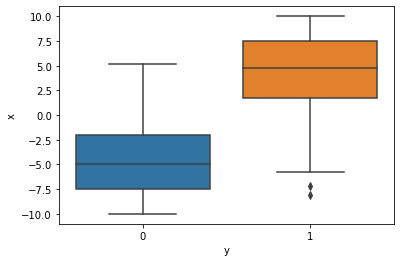

In [9]:
sns.boxplot(x='y', y='x', data=df)
plt.show()

Text(0, 0.5, 'y')

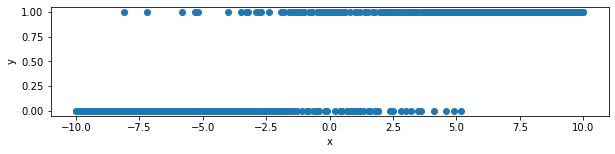

In [11]:
plt.figure(figsize=[10,2])
plt.scatter(df['x'], df['y'])
plt.xlabel('x')
plt.ylabel('y')

## 実験

`sample_ratio` Down Samplingの割合。Samplingなし(100%)から、5%まで、5%刻み

In [12]:
sample_ratio = [i for i in range(100, 4, -5)] 
sample_ratio

[100,
 95,
 90,
 85,
 80,
 75,
 70,
 65,
 60,
 55,
 50,
 45,
 40,
 35,
 30,
 25,
 20,
 15,
 10,
 5]

Down Samplingの実施と、ロジスティックモデルのあてはめ

In [13]:
df_dict = {}   # Samplingされたデータを「Ratio:サンプル割合」をkeyとして保存
datainfo_dict = {}  # Samplingされたデータ情報（N、0の数、1の数）
modparam_dict = {}   # モデルを「mod_サンプル割合」をkeyとして保存

for sr in sample_ratio:
    #print('----- {} -----'.format(sr))
    
    ### Doen Sampling
    r = sr/100
    df_y0 = df[df['y']==0]
    df_y1 = df[df['y']==1]
    nrow = df_y1.shape[0]
    df_y1 = df_y1.sample(int(nrow*r))   # y=1のデータのみsampling
    df_sampling = pd.concat([df_y0, df_y1]).sort_values('x')
    
    datainfo_dict['datainfo_'+str(sr)] = [df_sampling.shape[0], df_sampling['y'].value_counts()[0], df_sampling['y'].value_counts()[1]]
    
    ### ロジスティックモデルのあてはめ
    mod = smf.glm(formula='y ~ x', data=df_sampling, family=sm.families.Binomial()).fit()
    modparam_dict['mod_'+str(sr)] = mod.params   # モデルパラメータ（b0,b1）を保存
    
    ### 推定されたモデルによる予測
    df_sampling['pred_y'] = mod.fittedvalues
    
    df_dict['Ratio:'+str(sr)] = df_sampling   # Samplingされたデータ、モデル予測結果を保存

#### 結果：サンプリングされたデータ情報と、ロジスティックモデルの推定されたパラメータ（b0, b1）

In [14]:
df_info = pd.DataFrame(datainfo_dict).T
df_info = df_info.rename(columns={0:'N',1:'N_of_0',2:'N_of_1'}).reset_index(drop=True)

df_param = pd.DataFrame(modparam_dict).T
df_param = df_param.rename(columns={'Intercept':'b0','x':'b1'}).reset_index(drop=True)

df_res = pd.concat([pd.DataFrame(sample_ratio, columns=['Sampling_Ratio']), df_info, df_param], axis=1)
df_res

,Sampling_Ratio,N,N_of_0,N_of_1,b0,b1
0,100,402,197,205,0.097013,0.477093
1,95,391,197,194,0.035486,0.478474
2,90,381,197,184,0.037607,0.462092
3,85,371,197,174,-0.062857,0.483167
4,80,361,197,164,-0.169140,0.494070
5,75,350,197,153,-0.200366,0.473081
6,70,340,197,143,-0.225036,0.479174
7,65,330,197,133,-0.413872,0.515019
8,60,320,197,123,-0.518693,0.495622
9,55,309,197,112,-0.481106,0.461181


Down Samplingの割合が大きくなる（y=1のデータが少なくなる）につれ、推定値がズレていっている  
真のモデルは、$b0=0, b1=0.5$

#### 結果：データにモデル推定値を重ねたプロットを作成

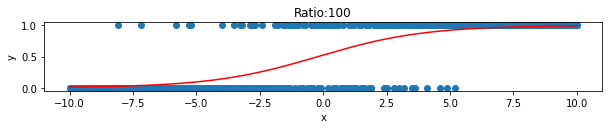

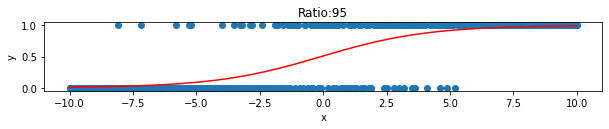

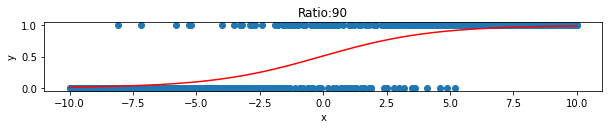

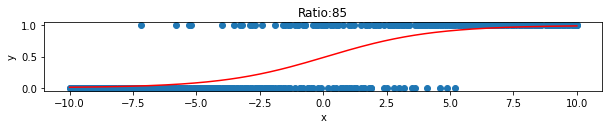

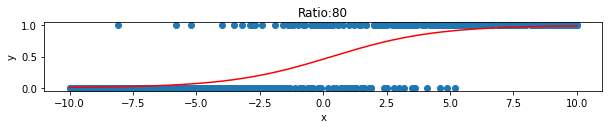

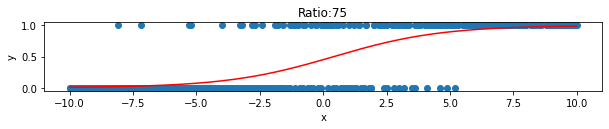

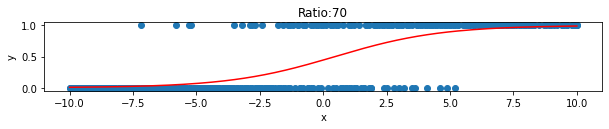

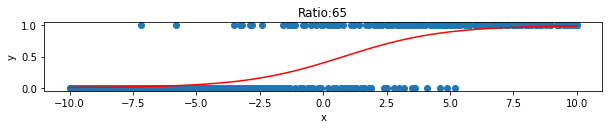

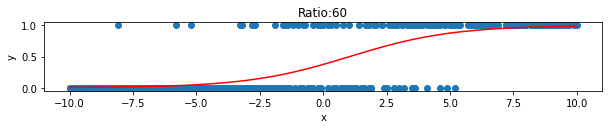

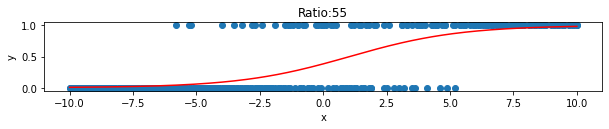

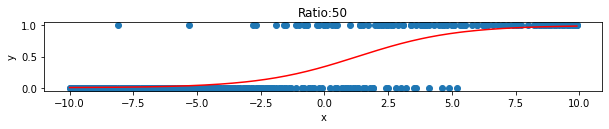

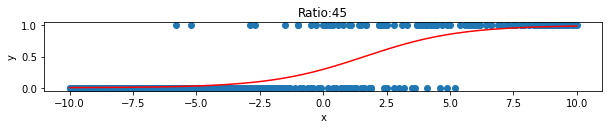

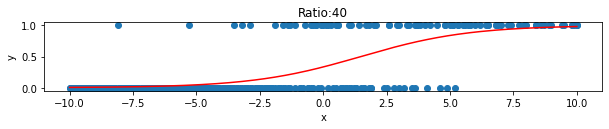

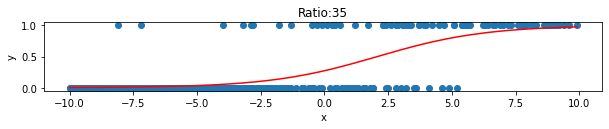

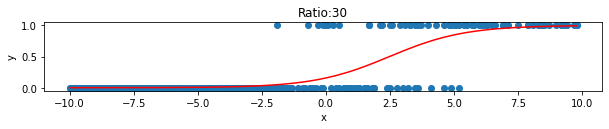

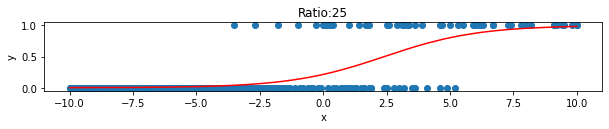

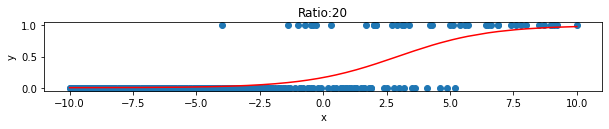

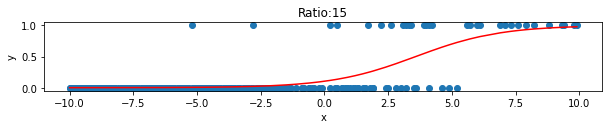

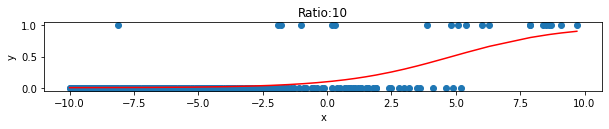

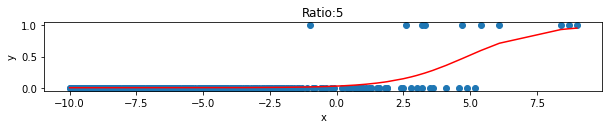

In [18]:
i = 1
for key,d in df_dict.items():
    plt.figure(figsize=[10,30])
    plt.subplot(len(df_dict),1,i)
    plt.scatter(d['x'], d['y'])
    plt.title(key)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(d['x'], d['pred_y'], color='red')
    plt.show()
    i += 1

データは仮定したモデルから生成されたものだが、データが十分でない、今回の例であればあるクラスのデータが少ない、といった状況だと、正しいモデルの推定が難しくなる